## 1. Exact rejection ABC

Develop an ABC sampler to estimate the probability $\pi$ of success in a negative binomial model where exactly $N+n$ trials are needed to obtain $n$ successes and $N$ failures with the last trial being successful.'

We assume that $n = 20$ and the data $X$ consists of a single observation $N = 35$.

1. Report the mean and standard deviation of the posterior $p(\pi | X)$ when the prior $p(\pi) = \mathrm{Beta}(\pi; 1.0, 1.0)$.
2. Report the mean and standard deviation of the posterior $p(\pi | X)$ when the prior $p(\pi) = \mathrm{Beta}(\pi; 5.0, 5.0)$.

Prior: Beta(pi,1.0,1.0)
mean: 0.3688166074120848 standard deviation: 0.06273258462122211
Prior: Beta(pi,5.0,5.0)
mean: 0.3839164078088673 standard deviation: 0.06472728605126575


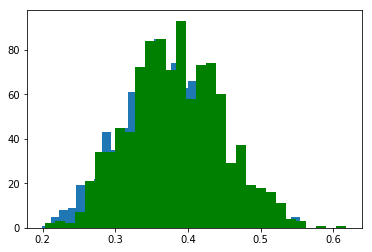

In [3]:
%matplotlib inline
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt

def abc_negabin(N, n, r, alpha, beta):
    samples = np.zeros(N)
    nsamples = 0
    while nsamples < N:
        pr = np.random.beta(alpha, beta, size=1)
        if np.random.negative_binomial(n=20,p=pr, size=1) == r:
            samples[nsamples] = pr
            nsamples += 1
    return samples

x=abc_negabin(1000,20,35,1.0,1.0)
print("Prior: Beta(pi,1.0,1.0)")
print("mean:", np.mean(x),"standard deviation:",np.std(x))
h = plt.hist(x, 30)
y=abc_negabin(1000,20,35,5.0,5.0)
print("Prior: Beta(pi,5.0,5.0)")
print("mean:", np.mean(y),"standard deviation:", np.std(y))
h = plt.hist(y, 30, color="green")

## 2. The effect of $\epsilon$ in ABC 

In this exercise we will study the effect of the tolerance parameter $\epsilon$ in ABC. We will use the data set loaded below as the data set $X = (x_1, \dots, x_n)$ and $S(X) = \mathrm{median}(X)$ as the summary statistic.

Our model is
$$ p(X | \theta) = \prod_{i=1}^n \mathrm{Laplace}(x_i;\; \theta, 1) $$
with the prior
$$ p(\theta) = \mathcal{N}(\theta;\; 0, 5^2). $$

1. Implement an ABC sampler that accepts proposals $\theta'$ when 
$$|S(X') - S(X)| < \epsilon.$$
Use your sampler to draw 100 samples with $\epsilon = 1$, $\epsilon = 0.1$ and $\epsilon = 0.01$. Plot a histogram of the samples in each case and compare the results. Report the mean and standard deviation of the samples drawn in each case to Moodle.
2. Implement an ABC sampler that accepts proposals $\theta'$ probabilistically with probability 
$$ a = \exp\left(-\frac{|S(X') - S(X)|^2}{2\epsilon^2}\right).$$
Use your sampler to draw 100 samples with $\epsilon = 1$, $\epsilon = 0.1$ and $\epsilon = 0.01$. Plot a histogram of the samples in each case and compare the results. Report the mean and standard deviation of the samples drawn in each case to Moodle.

In [4]:
import pandas as pd

data = pd.read_csv('http://www.helsinki.fi/~ahonkela/teaching/compstats1/toydata.txt', sep='\t', header=None)
data = data.values[:,0]


def abc_epsilon(N, epsilon):
    samples = np.zeros(N)
    nsamples = 0
    while nsamples < N:
        thetatahti = np.random.normal(0,5, size=1)
        if np.abs(np.median(np.random.laplace(loc=thetatahti,scale=1,size=500))- np.median(data))<epsilon:
            samples[nsamples] = thetatahti
            nsamples += 1
    return samples

print("Epsilon=1:")
print("sample mean:", np.mean(abc_epsilon(100,1)), "sample standard deviation:", np.std(abc_epsilon(100,1)))
print("Epsilon=0.1:")
print("sample mean:", np.mean(abc_epsilon(100,0.1)), "sample standard deviation:", np.std(abc_epsilon(100,0.1)))
print("Epsilon=0.01:")
print("sample mean:", np.mean(abc_epsilon(100,0.01)), "sample standard deviation:", np.std(abc_epsilon(100,0.01)))

Epsilon=1:
sample mean: 3.7220989454152194 sample standard deviation: 0.5718293277655412
Epsilon=0.1:
sample mean: 3.8342660580575045 sample standard deviation: 0.07820070000889993
Epsilon=0.01:
sample mean: 3.8355892930906164 sample standard deviation: 0.04599113372474336


In [5]:
def abc_epsilon_prob(N, epsilon):
    samples = np.zeros(N)
    nsamples = 0
    while nsamples < N:
        thetatahti = np.random.normal(loc=0,scale=5, size=1)
        sx=np.median(data)
        sxpilkku=np.median(np.random.laplace(loc=thetatahti,scale=1,size=500))
        ehto=np.exp(-(np.abs(sxpilkku-sx)**2/(2*epsilon**2)))
        if np.random.binomial(n=1,p=ehto)==1:
            samples[nsamples] = thetatahti
            nsamples += 1
    return samples

eka=abc_epsilon_prob(100,1)
toka=abc_epsilon_prob(100,0.1)
kolmas=abc_epsilon_prob(100,0.01)
print("Epsilon=1:")
print(np.mean(eka), np.std(eka))
print("Epsilon=0.1:")
print(np.mean(toka), np.std(toka))
print("Epsilon=0.01:")
print(np.mean(kolmas), np.std(kolmas))

Epsilon=1:
3.5502094883282154 0.9662659433796258
Epsilon=0.1:
3.851884815070867 0.11862086874790158
Epsilon=0.01:
3.8335873870106707 0.04751435826659506


In [7]:
# We see that standard deviation decreases with epsilon getting smaller. When epsilon =.01, 
# the results of both approaches do not differ significantly.

## 3. Rejection ABC for a dynamical model

In this task we will develop an ABC sampler for the autoregressive (AR) model:
$$ x_{t+1} = a x_t + \epsilon_t, \quad \epsilon_t \sim \mathcal{N}(0, \sigma^2). $$
We assume $x_0 = 1$. The model has two parameters, $a$ and $\sigma$. We set priors
$$ p(a) = \mathrm{Uniform}(a;\; 0, 1), \quad p(\sigma) = \mathrm{Gamma}(\sigma;\; k_\sigma, \theta_\sigma) $$
with $k_\sigma = 8, \theta_\sigma = 1/8$. Note that we use the shape/scale parametrisation also used by NumPy and that the prior is over $\sigma$, not $\sigma^2$ (also more consistent with NumPy parametrisation).

1. Implement a function to simulate the AR process. Test your function by generating and plotting two independent realisations of length 200 with $a = 0.75$, $\sigma = 0.2$. Notice how the sequences diverge relatively quickly and are essentially independent toward the end.
2. Implement an ABC sampler to infer the posterior over $a$ and $\sigma$ given the single observed sequence loaded below using the simulator implemented above and the summary statistics
$$ S(X) = \left( \frac{1}{N} \sum_{i=1}^N x_i^2, \frac{1}{N-1} \sum_{i=1}^{N-1} x_i x_{i+1} \right). $$
Run your sampler to generate samples with acceptance threshold $\| S(X) - S(X^*)\|_2 \le \epsilon$ with $\epsilon = 0.2$.
3. Report the approximate posterior means and standard deviations of $a$ and $\sigma$ to Moodle.

In [8]:
import pandas as pd
npr.seed=42

dataframe = pd.read_csv('http://www.helsinki.fi/~ahonkela/teaching/compstats1/ar_time_series_data.txt', header=None, sep='\t')
data = dataframe.values[:,0]

ksigma=8
musigma=1/8

ekakompo=(1/len(data))*np.sum(data**2)
summa=0
for i in range(len(data)-1):
    summa=summa+data[i]*data[i+1]
tokakompo=(1/((len(data))-1))*summa

SX=np.array([ekakompo, tokakompo])


def abc_regr(N, epsilon):
    samples = np.zeros((N,2))
    nsamples = 0
    while nsamples < N:
        a=np.random.uniform(0,1)
        sigma=np.random.gamma(ksigma,musigma)
    
        x0=1
        xs=np.zeros(200)
        for i in range(200):
            xs[i]=x0
            x0=a*x0+np.random.normal(loc=0,scale=sigma)
        sa=(1/200)*np.sum(xs**2)
    
        summa=0
        for i in range(len(data)-1):
            summa=summa+xs[i]*xs[i+1]
        ssigma=(1/((len(data))-1))*summa

    
        SXTAHTI=np.array([sa,ssigma])
        premi=((SXTAHTI[0]-SX[0])**2+(SXTAHTI[1]-SX[1])**2)
        ehto=np.sqrt(premi)
        if ehto<=epsilon:
            samples[nsamples] = np.array([a,sigma])
            nsamples += 1
    return samples

ajo=abc_regr(200,0.2)
print("Posterior mean of a:", np.mean(ajo[:,0]),"posterior std of a:", np.std(ajo[:,0]))
print("Posterior mean of sigma:", np.mean(ajo[:,1]),"posterior std of sigma:", np.std(ajo[:,1]))

Posterior mean of a: 0.8123661967262644 posterior std of a: 0.06911071183736714
Posterior mean of sigma: 0.6803689231830523 posterior std of sigma: 0.11120116170063164
